In [59]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [3]:
df = pd.read_csv("/Users/anchanghun/Downloads/Winter_AI_Study/dataset/CIC-IDS-2017/MachineLearningCVE/combiSCX.csv")

In [4]:
df["Flow Bytes/s"] = df["Flow Bytes/s"].fillna(df["Flow Bytes/s"].mean())

In [5]:
df["Flow Bytes/s"].isnull().sum()

0

In [6]:
df.shape

(2830743, 79)

In [7]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN


In [8]:
df.isnull().values.any()

False

In [9]:
len(df.columns)

79

/var/folders/lt/dt43ws7s4_z4rrsjwvzmwz740000gn/T/ipykernel_5529/254454083.py:20: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
/Users/anchanghun/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


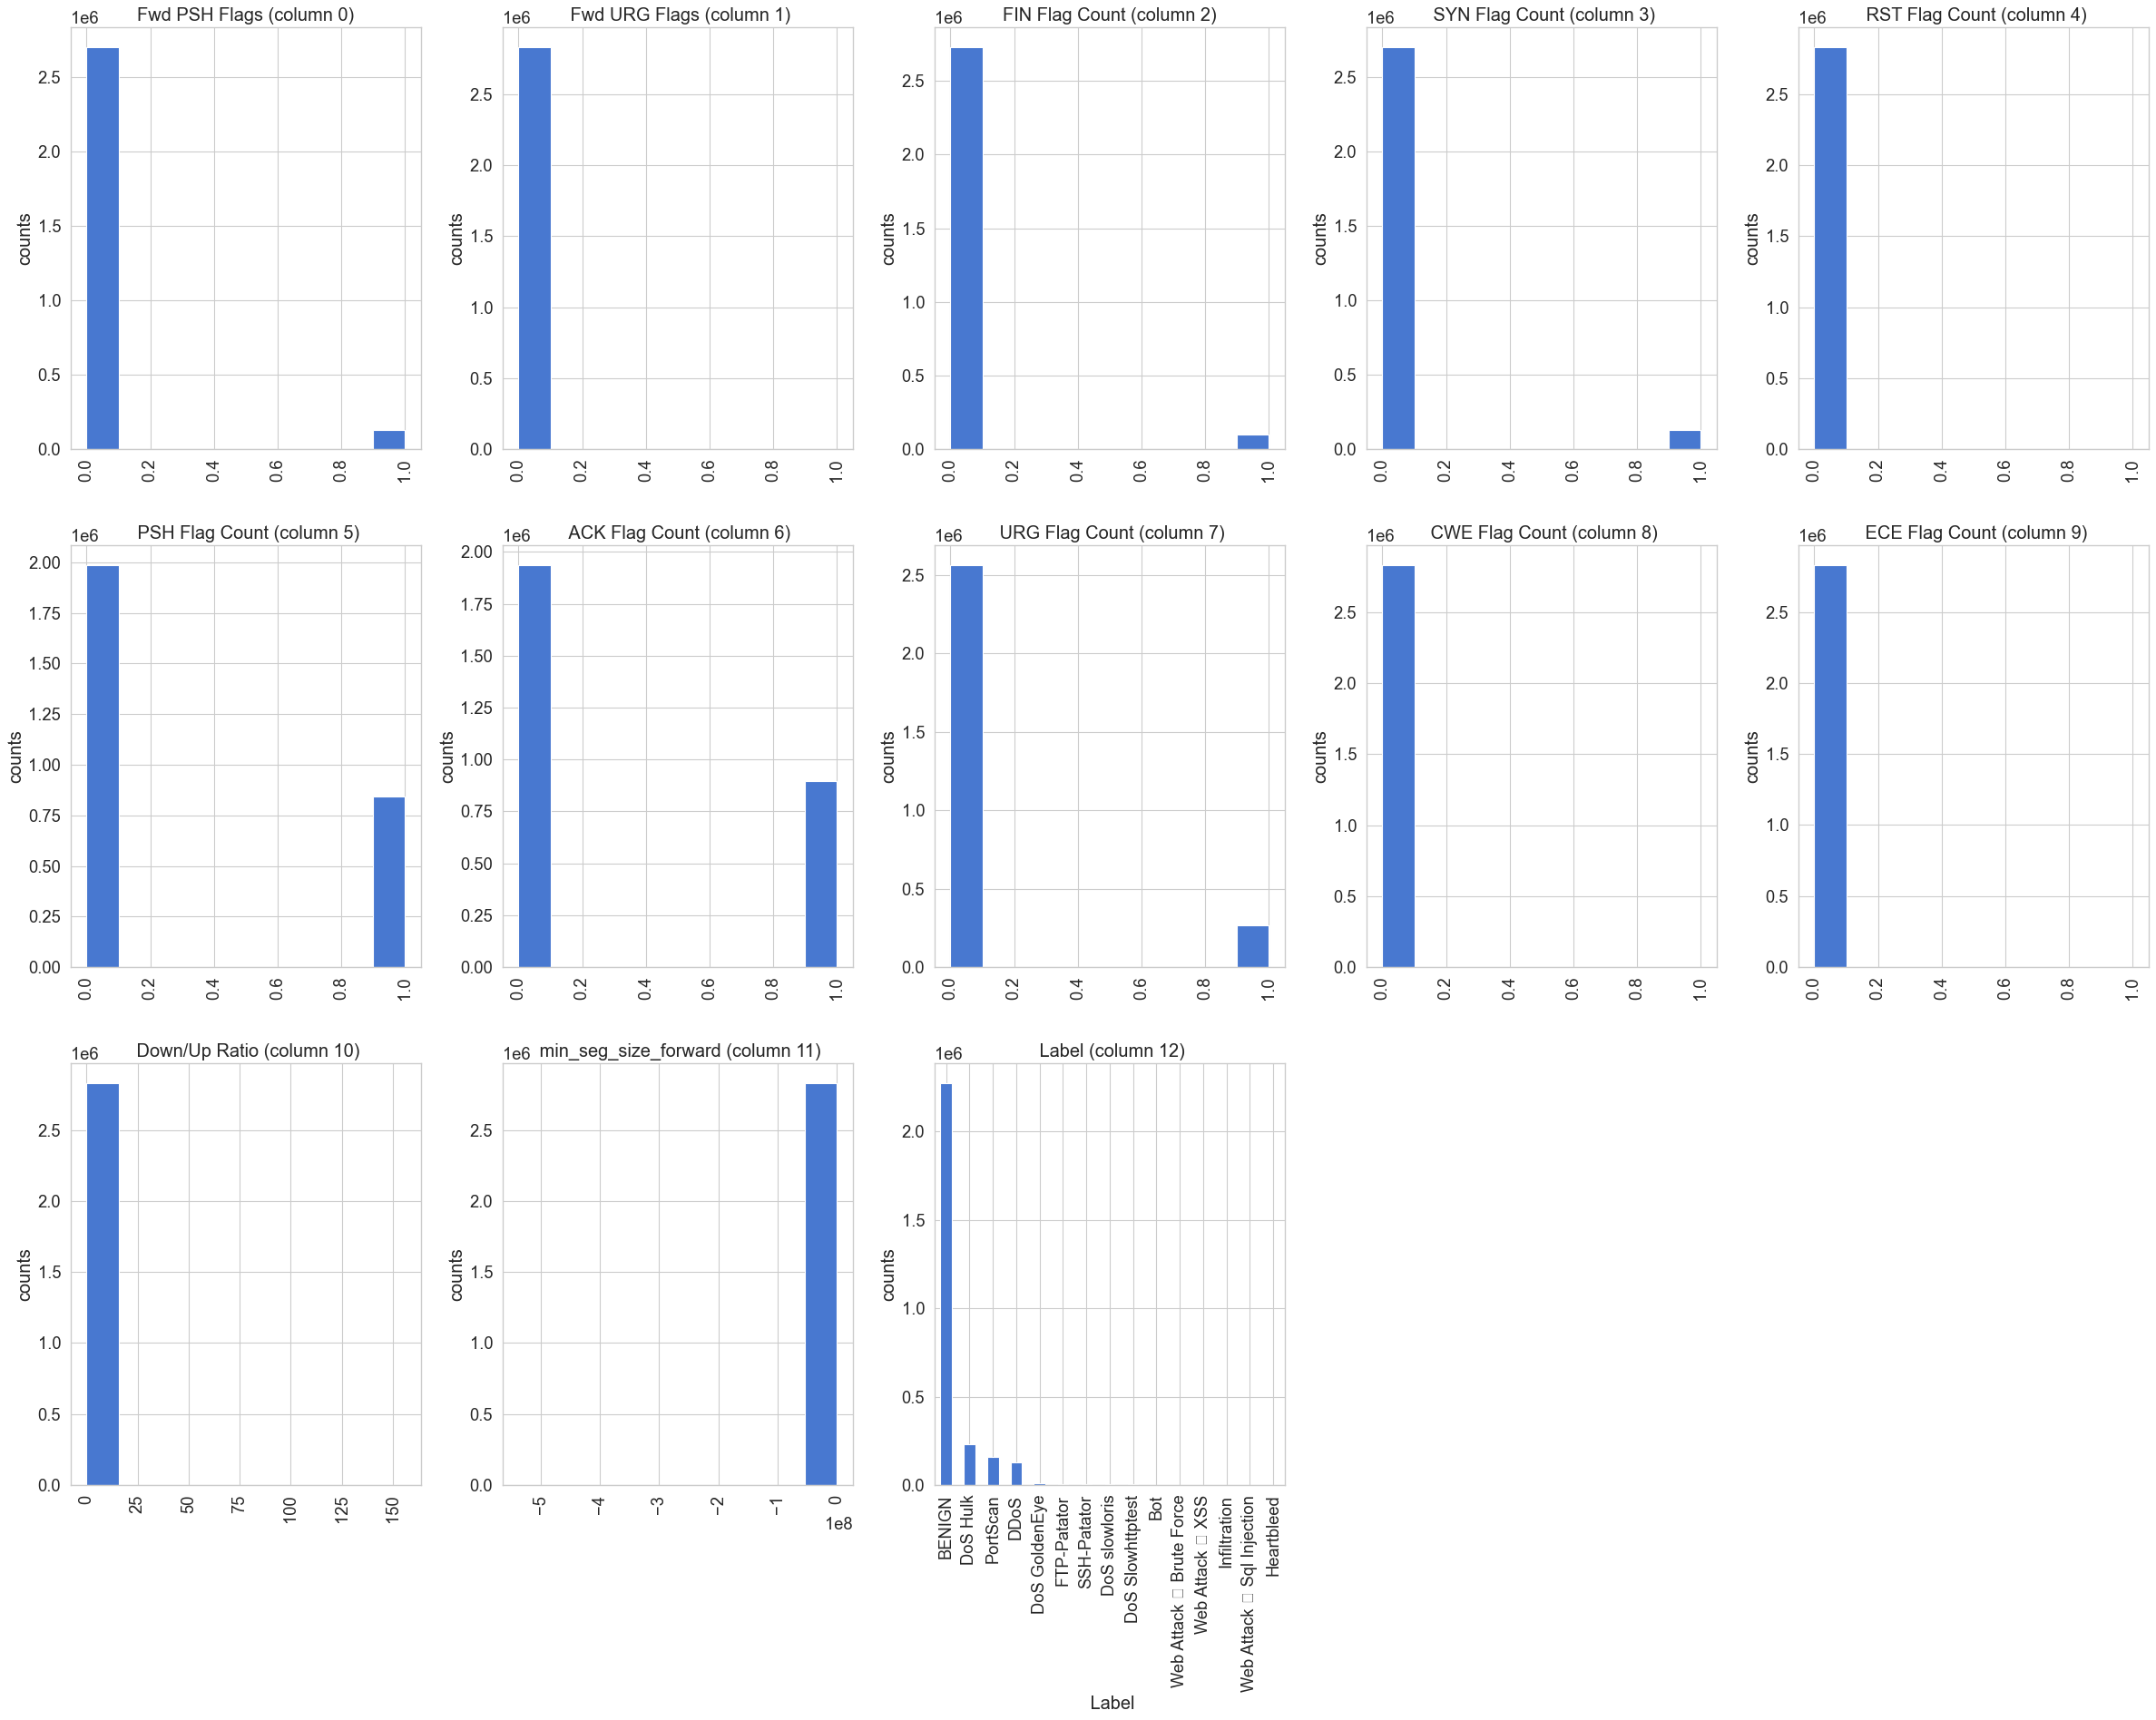

In [10]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
    
plotPerColumnDistribution(df, 79, 5)

In [11]:
def find_outliers(df):
    outliers_columns = []
    for column in df.columns:
        if df[column].dtype != 'object':
            std = df[column].std()
            if std > 0:
                z_score = (df[column] - df[column].mean()) / std
                if (np.abs(z_score) > 3).any():
                    outliers_columns.append(column)
        return outliers_columns

outliers_columns = find_outliers(df)
print("Columns with outliers (3 standard deviations or more away from the mean):", outliers_columns)

Columns with outliers (3 standard deviations or more away from the mean): [' Destination Port']


In [12]:
def find_invalid_columns(df):
    invalid_columns = []
    for column in df.columns:
        if df[column].dtype != object:  # 문자열이 아닌 경우에만 확인합니다.
            if np.any(np.isinf(df[column])) or np.any(np.abs(df[column]) > 1e10 ):
                invalid_columns.append(column)
    return invalid_columns

# 데이터프레임 df에서 불가능한 값을 포함하는 컬럼 찾기
invalid_cols = find_invalid_columns(df)

if invalid_cols:
    print("The following columns contain invalid values:")
    print(invalid_cols)
else:
    print("No columns contain invalid values.")

The following columns contain invalid values:
['Flow Bytes/s', ' Flow Packets/s', ' Fwd Header Length', ' Fwd Header Length.1']


In [13]:
#tmp = df[" Destination Port"]
#df = df.drop(columns=" Destination Port")

In [14]:
sorted_df = df.sort_values(by='Flow Bytes/s', ascending=False)
print(sorted_df['Flow Bytes/s'])

2067685            inf
390752             inf
154794             inf
2686789            inf
2190522            inf
              ...     
2438090    -12000000.0
571267     -12000000.0
538489     -12000000.0
1070584   -193000000.0
2688409   -261000000.0
Name: Flow Bytes/s, Length: 2830743, dtype: float64


In [15]:
threshold = 1e8  # 예시 임계값
inf_col = ['Flow Bytes/s', ' Flow Packets/s', ' Fwd Header Length', ' Fwd Header Length.1']

for col in inf_col:
    df[col] = np.clip(df[col], -threshold, threshold)

In [16]:

#Split dataset on train and test
from sklearn.model_selection import train_test_split
train, test=train_test_split(df,test_size=0.3, random_state=10)

#Exploratory Analysis
# Descriptive statistics
train.describe()
test.describe()

# Packet Attack Distribution
train[' Label'].value_counts()
test[' Label'].value_counts()

 Label
BENIGN                        680961
DoS Hulk                       69922
PortScan                       48025
DDoS                           38378
DoS GoldenEye                   3071
FTP-Patator                     2359
DoS slowloris                   1782
SSH-Patator                     1773
DoS Slowhttptest                1654
Bot                              613
Web Attack � Brute Force         462
Web Attack � XSS                 202
Infiltration                      13
Web Attack � Sql Injection         4
Heartbleed                         4
Name: count, dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [18]:
# importing one hot encoder from sklearn 
from sklearn.preprocessing import OneHotEncoder 

# creating one hot encoder object 
onehotencoder = OneHotEncoder() 

trainDep = train[' Label'].values.reshape(-1,1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()
testDep = test[' Label'].values.reshape(-1,1)
testDep = onehotencoder.fit_transform(testDep).toarray()

In [19]:
train_X=sc_traindf
train_y=trainDep[:,0]

test_X=sc_testdf
test_y=testDep[:,0]

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming train_X and test_X are your feature matrices, and train_y and test_y are your target vectors

# Standardize the data (important before applying PCA)
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Apply PCA
num_components = 10  # Adjust the number of components according to your needs
pca = PCA(n_components=num_components)

# Fit and transform the training data
train_X_pca = pca.fit_transform(train_X_scaled)

# Transform the testing data (using the same PCA transformation)
test_X_pca = pca.transform(test_X_scaled)

In [21]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Assuming train_X and test_X are your feature matrices, and train_y and test_y are your target vectors

# Standardize the data (important before applying PCA)
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Apply PCA
num_components = 20  # Use 20 components for PCA
pca = PCA(n_components=num_components)

# Fit and transform the training data
train_X_pca = pca.fit_transform(train_X_scaled)

# Transform the testing data (using the same PCA transformation)
test_X_pca = pca.transform(test_X_scaled)

# Select top 20 features using SelectKBest with the f_classif scoring function
feature_selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features

# Fit and transform the training data
train_X_selected = feature_selector.fit_transform(train_X_pca, train_y)

# Transform the testing data (using the same feature selection)
test_X_selected = feature_selector.transform(test_X_pca)

In [32]:
train_X_selected.shape

(1981520, 20)

In [34]:
input_dim = train_X_selected.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(train_X_selected, train_X_selected,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_X_selected, test_X_selected),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
61923/61923 [==============================] - 28s 450us/step - loss: 1.7771 - accuracy: 0.8571 - val_loss: 1.6836 - val_accuracy: 0.8739
Epoch 2/10
  427/61923 [..............................] - ETA: 21s - loss: 1.0608 - accuracy: 0.8689

/Users/anchanghun/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61923/61923 [==============================] - 27s 442us/step - loss: 1.6407 - accuracy: 0.8754 - val_loss: 1.6179 - val_accuracy: 0.8783
Epoch 3/10
61923/61923 [==============================] - 28s 446us/step - loss: 1.5937 - accuracy: 0.8730 - val_loss: 1.5865 - val_accuracy: 0.9092
Epoch 4/10
61923/61923 [==============================] - 28s 444us/step - loss: 1.5754 - accuracy: 0.8830 - val_loss: 1.5766 - val_accuracy: 0.8715
Epoch 5/10
61923/61923 [==============================] - 27s 444us/step - loss: 1.5657 - accuracy: 0.8835 - val_loss: 1.5702 - val_accuracy: 0.8958
Epoch 6/10
61923/61923 [==============================] - 28s 452us/step - loss: 1.5476 - accuracy: 0.8879 - val_loss: 1.5386 - val_accuracy: 0.9027
Epoch 7/10
61923/61923 [==============================] - 28s 451us/step - loss: 1.5295 - accuracy: 0.8876 - val_loss: 1.5222 - val_accuracy: 0.9073
Epoch 8/10
61923/61923 [==============================] - 27s 443us/step - loss: 1.5097 - accuracy: 0.8829 - val_loss

In [35]:
autoencoder = load_model('model.h5')

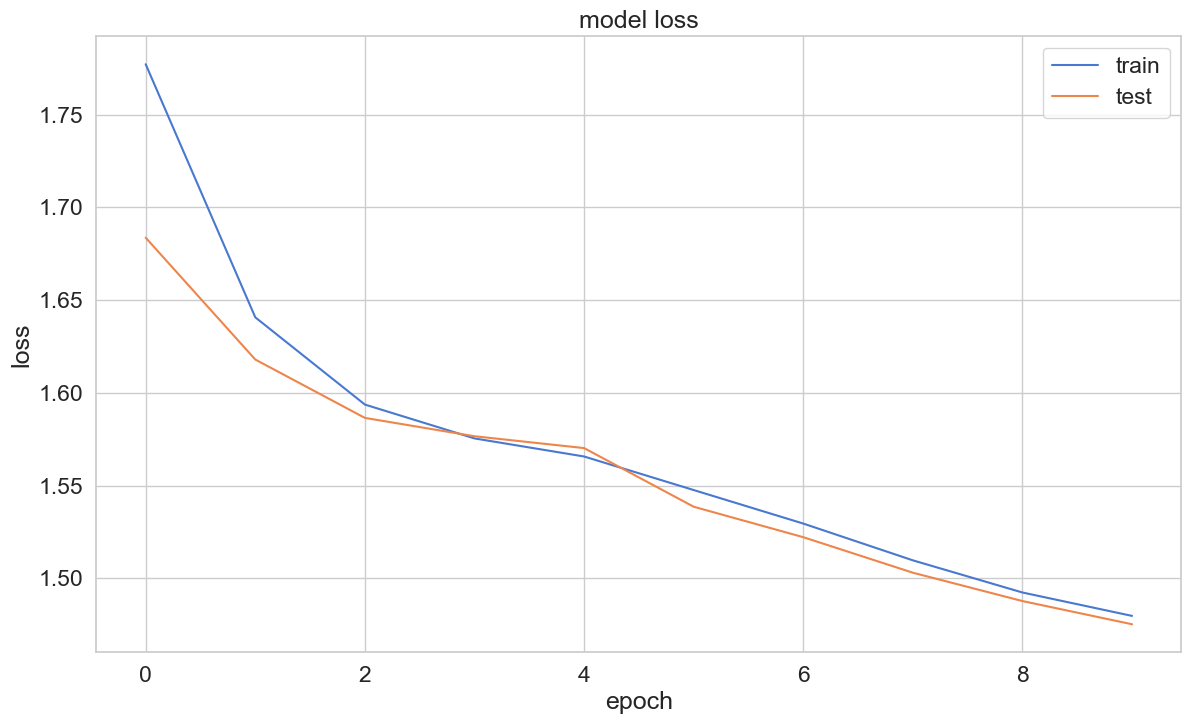

In [36]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [49]:
predictions = autoencoder.predict(test_X_selected)
mse = np.mean(np.power(test_X_selected- predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': test_y})
error_df.describe()

26539/26539 [==============================] - 5s 194us/step


,reconstruction_error,true_class
count,849223.000000,849223.000000
mean,1.474271,0.801864
std,103.226674,0.398596
min,0.049506,0.000000
25%,0.241255,1.000000
50%,0.332112,1.000000
75%,0.805356,1.000000
max,32722.032440,1.000000


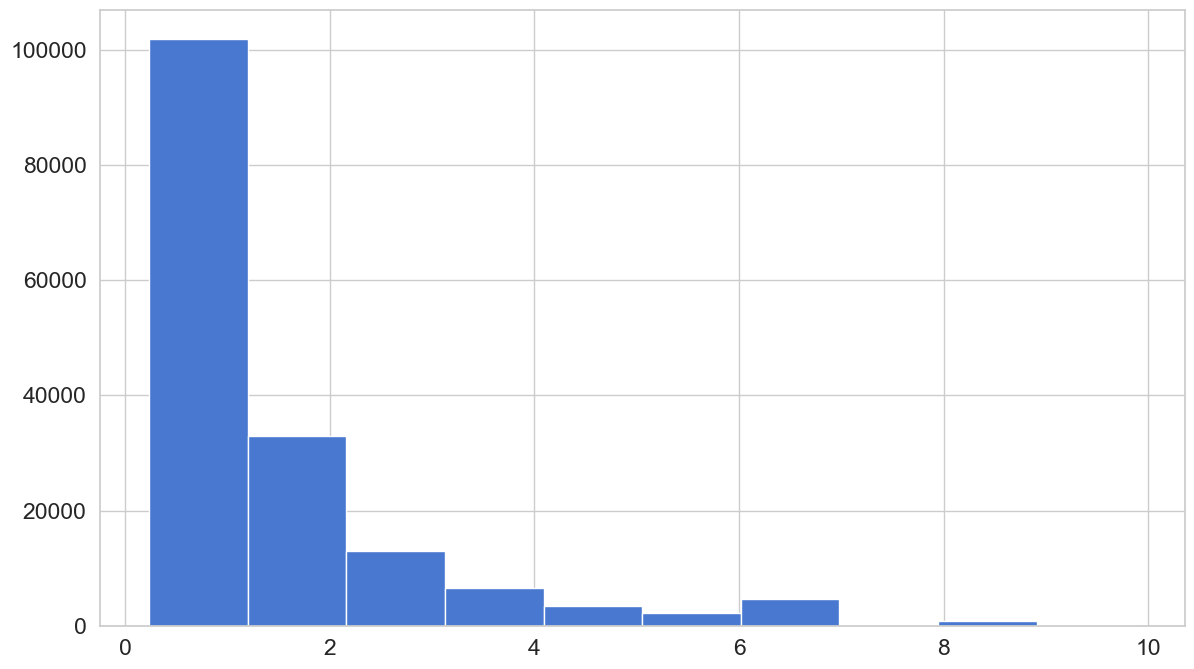

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

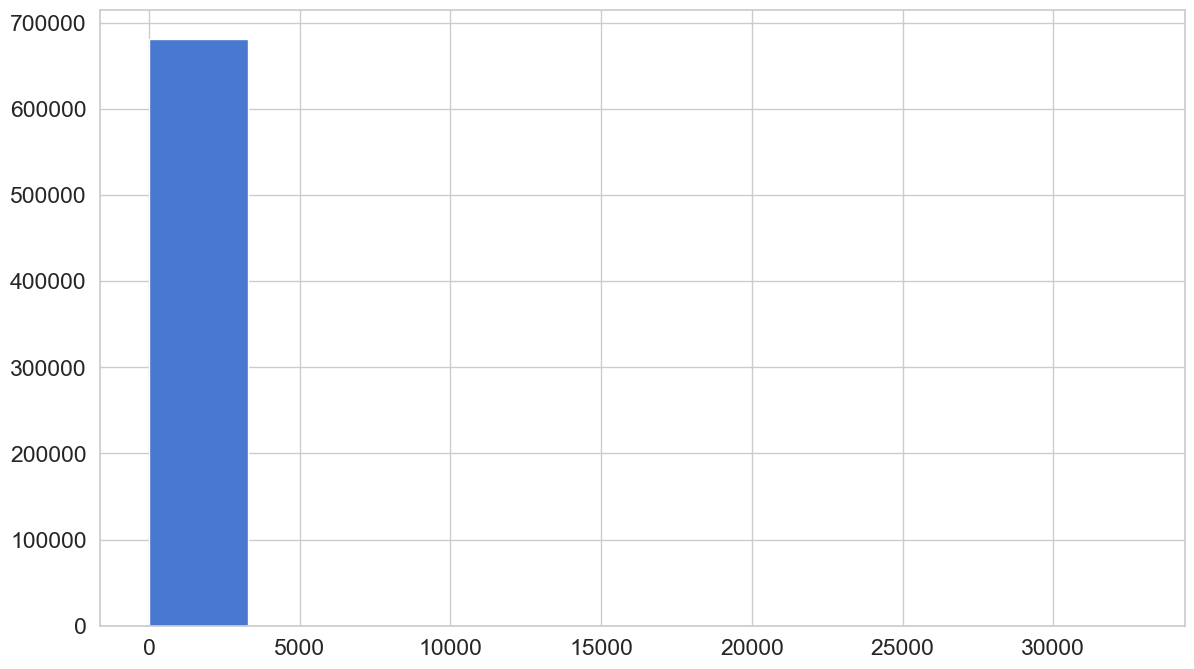

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [52]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

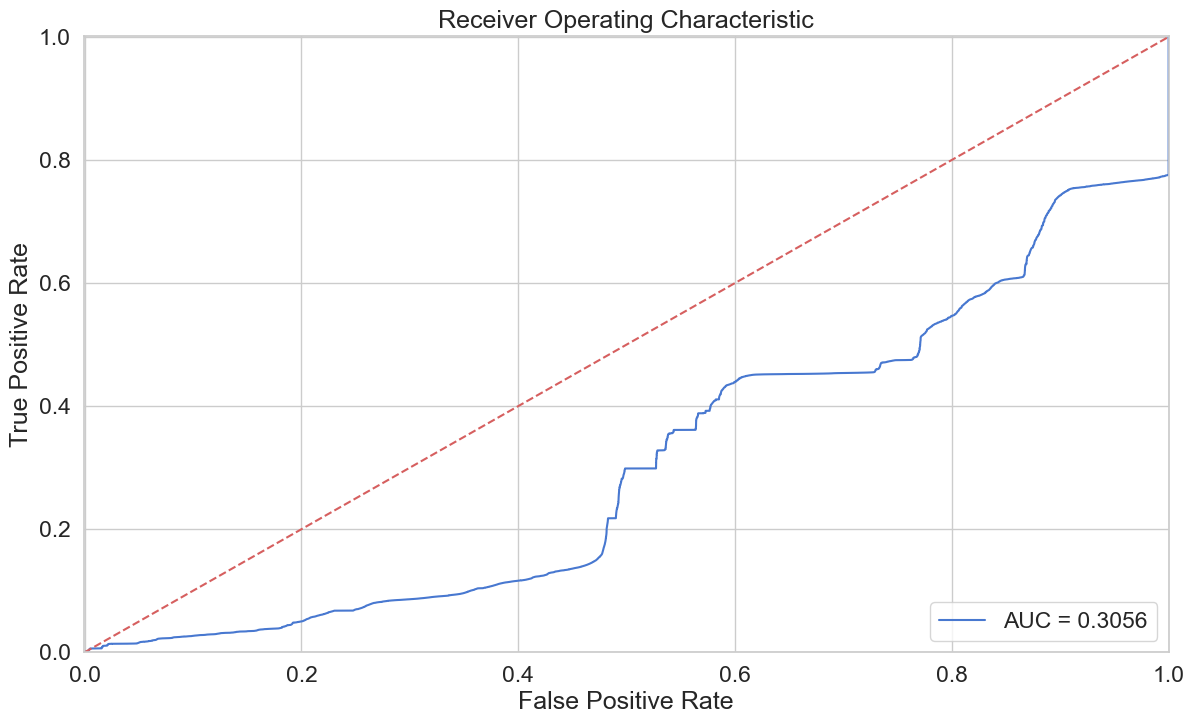

In [53]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

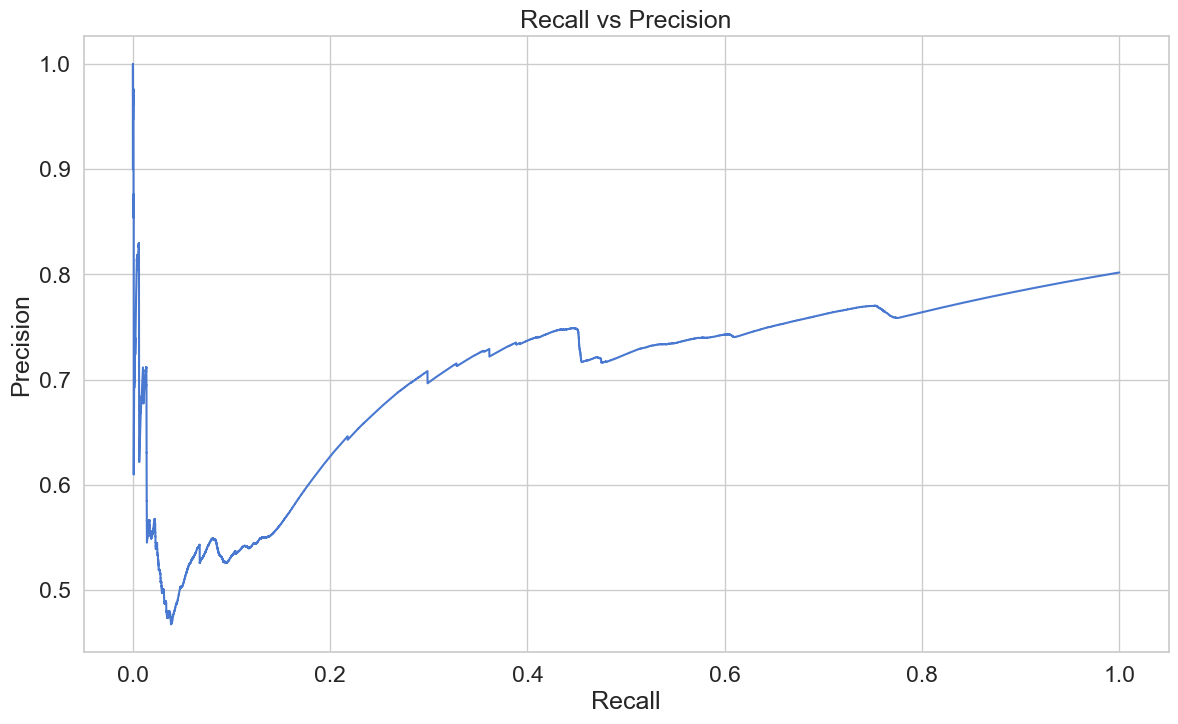

In [54]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

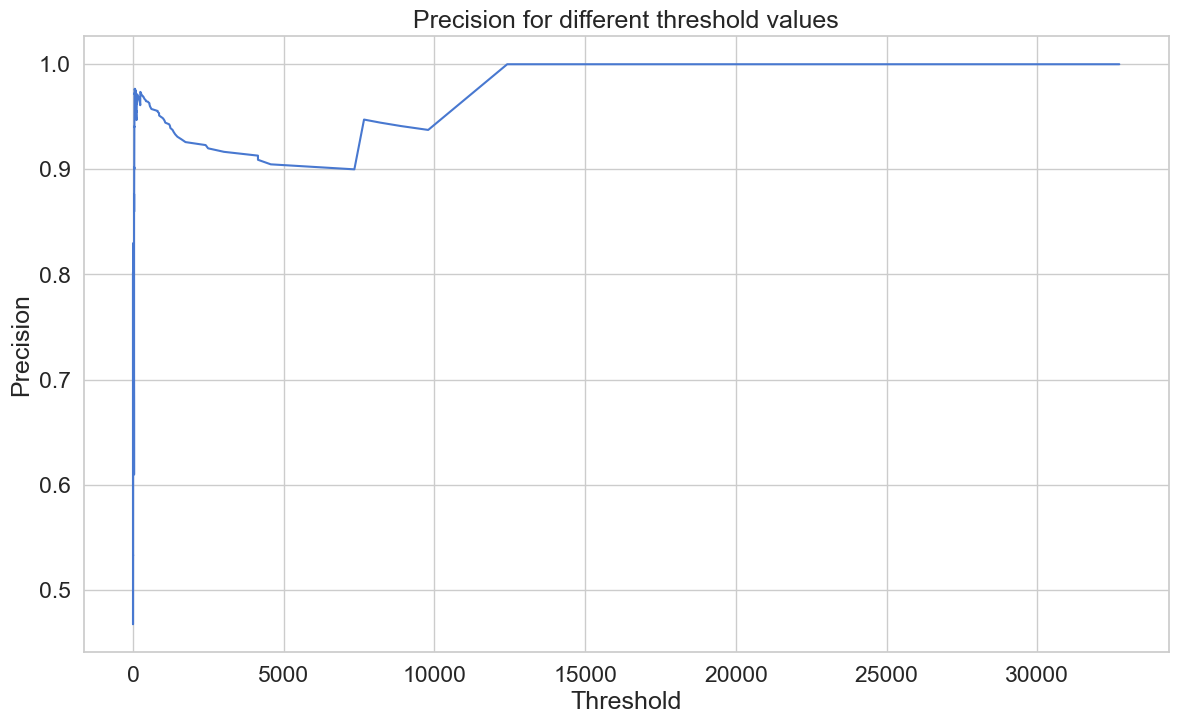

In [55]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

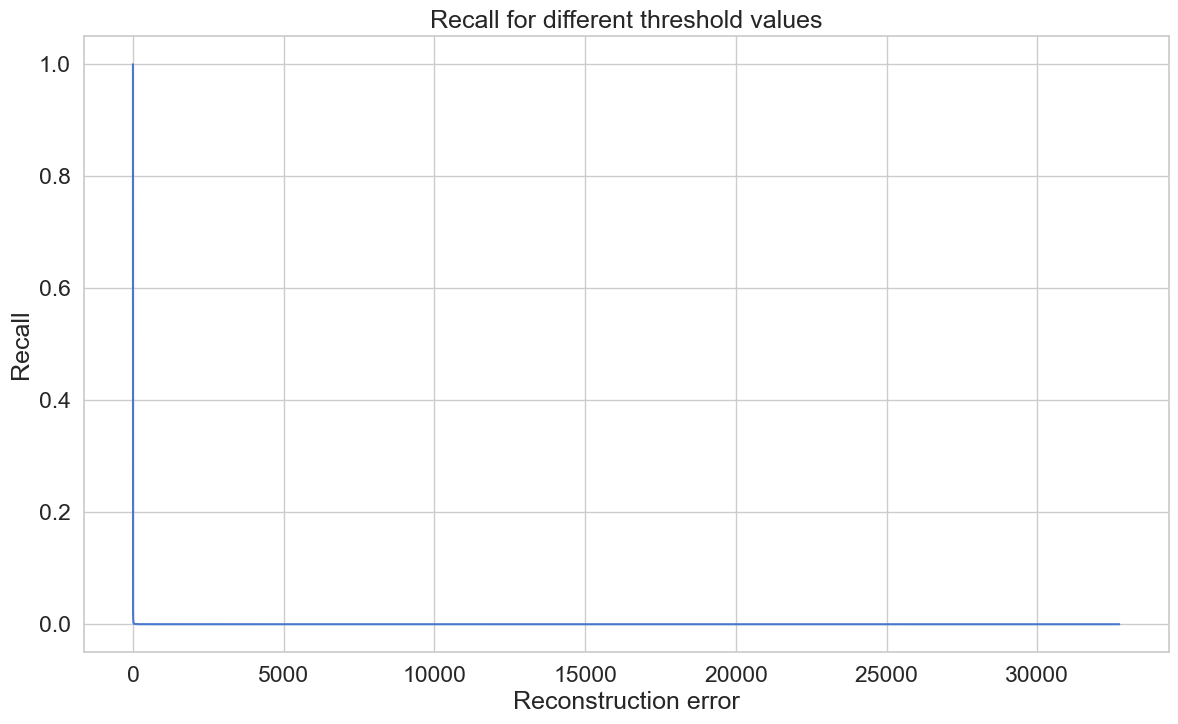

In [56]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

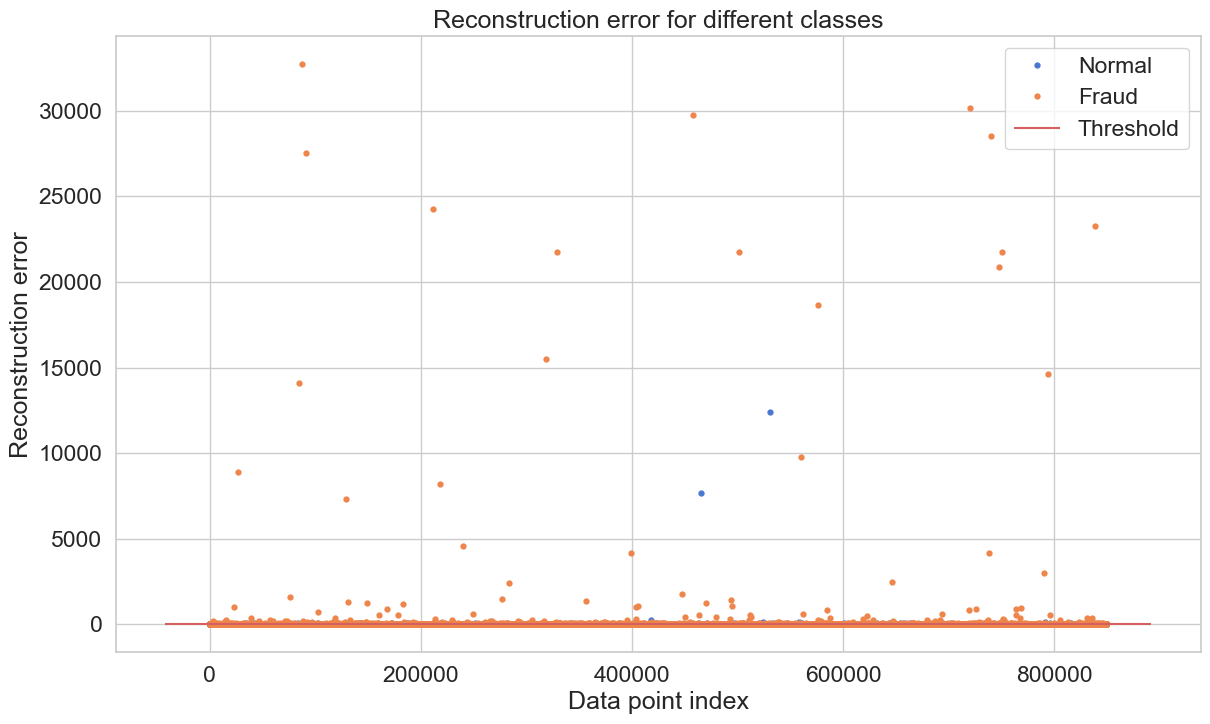

In [57]:
threshold = 2.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();